In [ ]:
Digital Signal Processing

Assignment #08

Group Members:

1. Navami Kairanda (Enrollment Number:2577665)
2. Pankhuri Vanjani (Enrollment Number:7009617)

In [44]:
import math
import numpy as np
from scipy.fft import dct, idct
import matplotlib.pyplot as plt
from matplotlib import cm
import soundfile as sf
import sounddevice
import pdb

In [45]:
#1.1 Pre-emphasize 
#to amplify the higher frequency 
#f′n=fn−αfn−1 α: 0.95
def preemphasis(audiostream, alpha=0.95):
    emph_audiostream = np.append(audiostream[0, None], audiostream[1:] - alpha * audiostream[:-1], axis=0)
    return emph_audiostream

point8, sample_rate = sf.read('point8.au') # (485100, 8), 44100, 11 sec

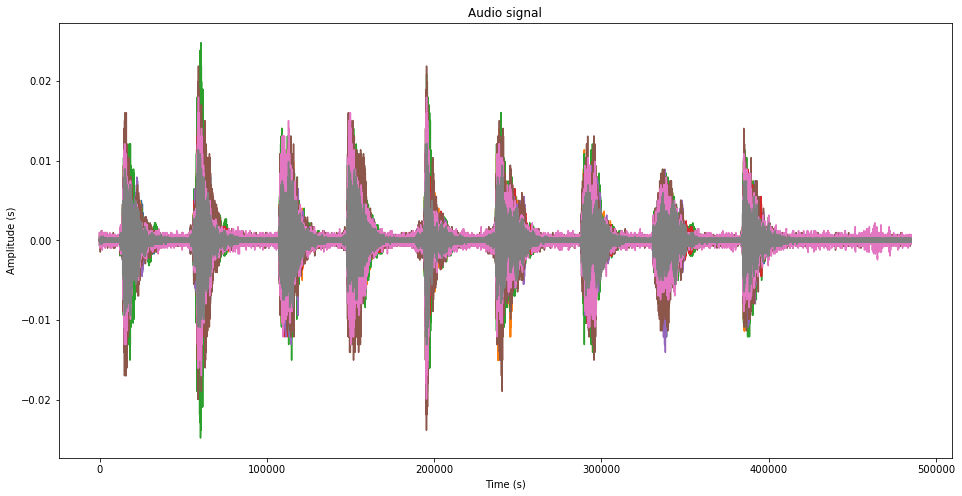

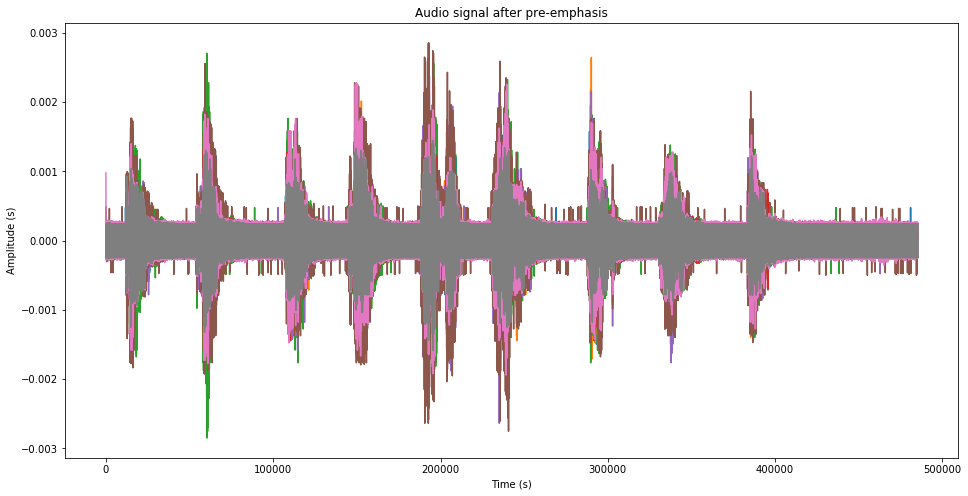

In [46]:

plt.figure(figsize=(16, 8))    
plt.plot(point8)
plt.title('Audio signal')
plt.xlabel('Time (s)') 
plt.ylabel('Amplitude (s)')
#plt.show()
plt.savefig('audio_signal.png')

point8_emph = preemphasis(point8)

plt.figure(figsize=(16, 8))  
plt.plot(point8_emph)
plt.title('Audio signal after pre-emphasis')
plt.xlabel('Time (s)') 
plt.ylabel('Amplitude (s)')
#plt.show()
plt.savefig('audio_signal_emph.png')


In [47]:
#1.2 Framing and windowing 
def frame_window(signal, frame_shift, frame_width):
    k = signal.shape[0]

'''
frame_shift = 44100
frame_width = 44100
frame_window(point8_emph, frame_shift, frame_width)
'''

frame_size = 0.025
frame_stride = 0.01

#pdb.set_trace()
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(point8_emph)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length, point8_emph.shape[1]))
#pdb.set_trace()
pad_signal = np.append(point8_emph, z, axis=0) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T # [num_frames, frame_length]
frames = pad_signal[indices.astype(np.int32, copy=False)]

frames *= np.repeat(np.hamming(frame_length)[None], point8_emph.shape[1], axis=0).T


2.  How many frames can be produced from k samples?

k/(width frames generated in total)

In [48]:
# 1.3 Mel-Filterbank
def hz2mel(f_hz):
    f_mel = 2595 * math.log10(1 + f_hz / 700)
    return f_mel

def mel2hz(f_mel):
    f_hz = (700 * (10**(f_mel / 2595) - 1))
    return f_hz

def mel_filterbank(fl, fh, nfft, fs, L):
    mel_fl = hz2mel(fl)
    mel_fh = hz2mel(fh)
    mel_points = np.linspace(mel_fl, mel_fh, L+2)
    hz_points = mel2hz(mel_points)
    f = np.floor((nfft + 1) * hz_points / fs) 
    filter_bank = np.zeros((L, int(np.floor(nfft / 2 + 1))))
    
    for m in range(1, L+1):
        for k in range(int(f[m-1]), int(f[m])):
            filter_bank[m-1, k] = 2 * (k - f[m-1]) / ((f[m+1] - f[m-1]) * (f[m] - f[m-1]))
        for k in range(int(f[m]), int(f[m+1])):
            filter_bank[m-1, k] = 2 * (f[m+1] - k) / ((f[m+1] - f[m-1]) * (f[m+1] - f[m]))
    return filter_bank

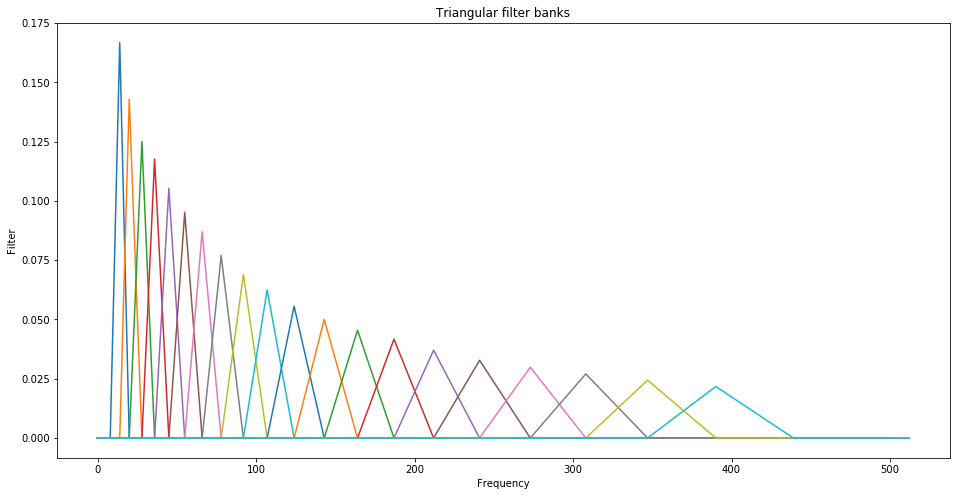

In [49]:
fl = 133 # Hz
fh = 6855 # Hz
fs = 16000 # Hz
nfft = 1024 #1024
L = 20
num_ceps = 12

filter_bank = mel_filterbank(fl, fh, nfft, fs, L)

fig = plt.figure(figsize=(16, 8))  
ax = fig.gca()
for filter in filter_bank:
    ax.plot(filter) 
plt.title('Triangular filter banks')
plt.xlabel('Frequency') 
plt.ylabel('Filter')
#plt.show()
plt.savefig('mel_filterbank.png') 

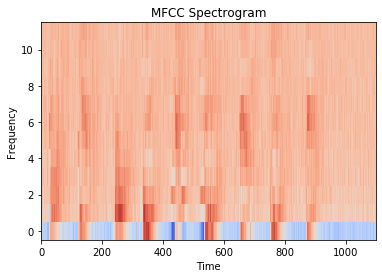

In [50]:
# 1.4 MFCC Implementation
channel_idx = 0
mag_frames = np.absolute(np.fft.rfft(frames[...,channel_idx], nfft))  # Magnitude of the FFT,
# (1098, 1102, 257) if fft over all channels, (1098, 257) if single channel
pow_frames = ((1.0 / nfft) * ((mag_frames) ** 2))  # Power Spectrum

filter_banks = np.dot(pow_frames, filter_bank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps +1)] 



fig, ax = plt.subplots()
mfcc_data = np.swapaxes(mfcc, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC Spectrogram')
ax.set_xlabel('Time') 
ax.set_ylabel('Frequency')
plt.savefig('mfcc_spectrogram.png') 


1.4.3 Why can we discard the DCT coefficient 0 in this implementation?

The zeroth coefficient is often excluded since it represents the average log-energy of the input signal (which only carries little speaker-specific information)

In [51]:
# 1.5 Dynamic features
def dynamic_feature(data):
    (num_frames, num_ceps) = data.shape
    features = np.zeros(data.shape)
    for m in range(1, num_ceps):
        for i in range (1, num_frames-1):
            features[i][m] += (data[i-1][m] - data[i+1][m]) / 2
    return features

first_order_features = dynamic_feature(mfcc)
second_order_features = dynamic_feature(first_order_features)

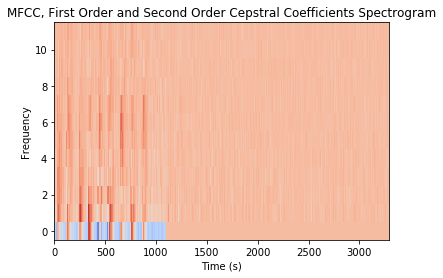

In [52]:
all_features = np.concatenate((mfcc, first_order_features, second_order_features), axis=0)
fig, ax = plt.subplots()
features_data = np.swapaxes(all_features, 0 ,1)
cax = ax.imshow(features_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC, First Order and Second Order Cepstral Coefficients Spectrogram')
ax.set_xlabel('Time (s)') 
ax.set_ylabel('Frequency')
plt.savefig('features_spectrogram.png') 